# Building and training a Multi Layered Perceptron (MLP) using Tensorflow

To run a code cell, click on the cell the press "Shift + Enter"

### Import required libraries

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib import cm

#Want to use version of Tensorflow > 2.0
print('Using Tensorflow version %s' % tf.__version__)


Using Tensorflow version 2.2.0


Let's generate a dataset, consisting of two data types which we call signal and background. Each data type is normally generated around a point in the x-y plane. Distinguishing signal from backgorund is a very simple problem. You could use PDFs and likelihoods identify signal and backgound. We will build a very simply MLP classifier to identify events as signal or background

In [ ]:
#Create datasets
num_events = 10000

#Signal x and y mean values
signal_mean = [1.0, 1.0]
#Signal x and y values are uncorrelated
signal_cov = [[1.0, 0.0],
              [0.0, 1.0]]

#Generate a training and validation sample
signal_train = np.random.multivariate_normal(
        signal_mean, signal_cov, num_events)
signal_val = np.random.multivariate_normal(
        signal_mean, signal_cov, num_events)

#Background x and y mean values
background_mean = [-1.0, -1.0]
#Background x and y values are uncorrelated
background_cov = [[1.0, 0.0],
                  [0.0, 1.0]]

#Generate a training and validation sample
background_train = np.random.multivariate_normal(
        background_mean, background_cov, num_events)
background_val = np.random.multivariate_normal(
        background_mean, background_cov, num_events)

#Add the signal and background samples
data_train = np.vstack([signal_train, background_train])
labels_train = np.vstack([np.ones((num_events, 1)), np.zeros((num_events, 1))])

#Add the signal and background samples
data_val = np.vstack([signal_val, background_val])
labels_val = np.vstack([np.ones((num_events, 1)), np.zeros((num_events, 1))])

In [ ]:
#Plot the datasets generated
range_ = ((-3, 3), (-3, 3))
plt.figure(0, figsize=(8,4))
plt.subplot(1,2,1); plt.title("Signal")
plt.xlabel("x"), plt.ylabel("y")
plt.hist2d(signal_train[:,0], signal_train[:,1],
        range=range_, bins=20, cmap=cm.coolwarm)
plt.subplot(1,2,2); plt.title("Background")
plt.hist2d(background_train[:,0], background_train[:,1],
        range=range_, bins=20, cmap=cm.coolwarm)
plt.xlabel("x"), plt.ylabel("y");

Because this is a simple problem we can build a simple MLP to identify signal and background events 

In [ ]:
# Let's use Tensorflows sequential API. We pass the layers to the API sequentially
#Construct Neural Net

model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation="relu", input_dim=2))
model.add(keras.layers.Dense(1, activation="sigmoid"))

It is useful to look at the architecture of your neural net to check it makes sense. Do you have the total number of parameters you would expect to have. Use the model's method .summary() to see a breakdown of your neural net

In [ ]:
model.summary()

Set loss function and optimiser. As this is a classification neural net we want to use binary cross entropy as the loss function. We will use adam as the optimiser

In [ ]:
# Set loss function and optimiser
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


Train on data. Define the dataset you want to train on and the validation set you want to validate the training against. Set the number of epochs (the number of iterations over the dataset). Set the batch size. This is a number/size of events smaller than your dataset that you run over and update the weights of your neural net. You run over multiples of batch sizes until you have run over all your events in your dataset. That is one epoch.  The batch size can actually be quite important. A small batch size can be good if you are low on computer memory or want to avoid getting stuck in a local minima. Too small a batch size can make converging on optimal weighs slow!

In [ ]:
num_epochs = 200
#Not worried about memory or local minima
batchSize = len(data_train)

#Train on data
history = model.fit(data_train, labels_train,
          validation_data=(data_val, labels_val),
          batch_size=len(data_train),
          epochs=num_epochs)


92% accurracy. Not bad! Be careful with accuracy measurments. It is easy to measure high accuracy if your validation or test sample mainly has one category of data. Not the case here!

Plot the loss of the neural net as a function of epoch

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

What about saving the model. Also at what point do save the model. This is an ideal example where the loss is smooth and decreases monotonically. You'll find this is rarely the case. What I tend to do is save the model each time the validation loss reaches a minimum. You overtrain your neural net if you use the training loss as a metric for saving your model. Let's use a callback to save the model. A callback kets you specify a list of objects that will be called during training. We can use a callback to save the model every time the validation loss is at a minimum

In [ ]:
import os

#Specify a directory to save model

model_filename = 'simple_mlp.h5'
saved_model_directory = 'models'

checkpoint_filename = os.path.join(saved_model_directory, model_filename)

CHECK_FOLDER = os.path.isdir(saved_model_directory)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(saved_model_directory)
    print("created folder : ", saved_model_directory)
                
#Create checkpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filename,
        monitor='val_loss',
        save_weights_only=True,
        save_best_only=True,
        verbose = 1)

        
history = model.fit(data_train, labels_train,
        validation_data=(data_val, labels_val),
        batch_size=len(data_train),
        epochs=num_epochs,
        callbacks=[model_checkpoint_callback])

In [ ]:
#Load model

model.load_weights(checkpoint_filename)


## Image classification with a MLP

We can look at the MNIST dataset, famous in machine learning examples. Specifically we can look at images of handwritten numbers 0-9 and use a MLP to identify them. This is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the <a id='http://yann.lecun.com/exdb/mnist'>MNIST homepage</a>.

Image label is: 0


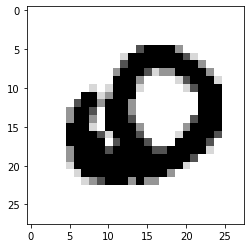

In [27]:
#Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


# Randomly look at one of the images
random_ints =np.random.randint(len(x_test), size=1)
image_index = random_ints[0]

plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')

print('Image label is: %i' % y_test[image_index])


Let's build an mlp to identify the images. The intenstiy of the pixels is represented as a value from 0 to 255. We should normalise the intensity. Also, the image is a 2D array so we should flatten it to a 1D array so the values can be input into a MLP. Lets build a simple MLP with a hidden layer containing 128 nodes and an output layer of 10 nodes

In [28]:
# Intensity of pixels ranges from 0-255. We need to normalise them
x_train, x_test = x_train / 255.0, x_test / 255.0


#Rather than instantiate the node and use the .add method to keep adding input,layers, outputs, etc we can just state
#components separated by a comma during instantiation

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


One would expect some kind of sigmoid activation function to be applied to the output. However we let the loss function SparseCategoricalCrossentropy take the output and use it to calculate the loss to best attribute probabilities to each output

In [29]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])


Train the model!

In [30]:
#Split into training and validation samples
x_train, x_val = x_train[0:55000], x_train[55000:]
y_train, y_val = y_train[0:55000], y_train[55000:]
num_epochs = 10

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=num_epochs)

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2743 - accuracy: 0.9217 - val_loss: 0.1338 - val_accuracy: 0.9608
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.1221 - accuracy: 0.9638 - val_loss: 0.0925 - val_accuracy: 0.9734
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0832 - accuracy: 0.9753 - val_loss: 0.0828 - val_accuracy: 0.9760
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0628 - accuracy: 0.9814 - val_loss: 0.0776 - val_accuracy: 0.9780
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0479 - accuracy: 0.9853 - val_loss: 0.0773 - val_accuracy: 0.9798
Epoch 6/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0379 - accuracy: 0.9882 - val_loss: 0.0838 - val_accuracy: 0.9772
Epoch 7/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.0305 - accuracy: 0.9906 - val_loss: 0.0713 - val_ac

99%, pretty good!

Add sections on learning rate scheduling (default learning rate is 1e-2), dropout